## Expectation-Maximization algorithm (E-M)

The expectation-maximization algorithm is an iterative method to find maximum likelihood (ML) estimates of parameters in statistical models. The E-M algorithm alternates between performing an expectation (E) step, which creates a function for the expectation of the log-likelihood evaluated using the current estimate for the parameters, and a maximization (M) step, which computes parameters maximizing the expected log-likelihood found on the E step. This alternation repeats until convergence.

The goal of this project is to perform E-M first on a sample Gaussian mixture model (GMM). Doing this will prove that the algorithm works, since the parameters of the model are already known.

In [5]:
from matplotlib.patches import Ellipse
from scipy.special import logsumexp
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math

**a. Data creation.** Create 3 2D Gaussian clusters of data, with the following means and covariances:

$\boldsymbol{\mu}_1 = [2,2]^T, \boldsymbol{\mu}_2 = [-2,-2]^T, \boldsymbol{\mu}_3 = [0,-2]^T$,

$\Sigma_1 = [[0.02,0];[0,0.02]]$, $\Sigma_2 = [[0.2,0];[0,0.2]]$, $\Sigma_3 = [[0.05,0];[0,0.05]]$ 

Create 50 points in each cluster and plot the data. The combination of these will serve as the Gaussian mixture model.

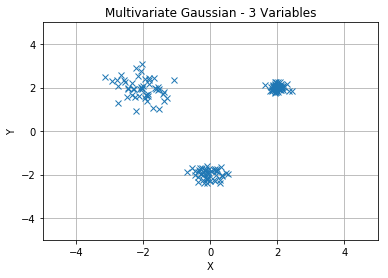

In [6]:
# Part a - data creation. This code is from the previous homework. You do not have to edit it.
num_pts = 50
x1, y1 = np.random.multivariate_normal([2,2], [[0.02,0],[0,0.02]], num_pts).T
x2, y2 = np.random.multivariate_normal([-2,2], [[0.2,0],[0,0.2]], num_pts).T
x3, y3 = np.random.multivariate_normal([0,-2], [[0.05,0],[0,0.05]], num_pts).T

# Concatenate clusters into one dataset
x_total = np.zeros((3*num_pts,1))
x_total[0:num_pts,0] = x1
x_total[num_pts:2*num_pts,0] = x2
x_total[2*num_pts:3*num_pts,0] = x3

y_total = np.zeros((3*num_pts,1))
y_total[0:num_pts,0] = y1
y_total[num_pts:2*num_pts,0] = y2
y_total[2*num_pts:3*num_pts,0] = y3

data = np.concatenate((x_total,y_total),axis=1)

# Plotting
plt.plot(x_total,y_total,'x')
ax = plt.gca()
ax.set_xlim([-5,5])
ax.set_ylim([-5,5])
plt.grid()
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Multivariate Gaussian - 3 Variables')
plt.show()

**b. Complete the EM algorithm given below.** The EM algorithm is given by a process similar to k-means/DP-means in nature, since it is iterative. However, the actual calculations done are very different. For a Gaussian mixture model, they are described by:

*E-Step (Compute probabilities with given Gaussian parameters)*


*M-Step (Update parameters. The subscript c denotes the parameter for a given cluster c, so this is calculated for each cluster.):*
\begin{equation*}
n\_per\_cluster = \sum_{i=1}^{n\_points} \gamma(z_{ic})
\end{equation*}

\begin{equation*}
\pi_c = \frac{n\_per\_cluster}{n\_points}
\end{equation*}

\begin{equation*}
\mu_c = \frac{1}{n\_per\_cluster} * \sum_{i=1}^{n\_points} \gamma(z_{ic}) * x_i 
\end{equation*}

\begin{equation*}
\Sigma_c = \frac{1}{n\_per\_cluster} * \sum_{i=1}^{n\_points} \gamma(z_{ic}) * (x_i - \mu_c)(x_i - \mu_c)^T 
\end{equation*}


*Repeat until convergence. To check for convergence, we check if the log-likelihood estimate is close enough to the previous estimate to stop the algorithm. To compute the log-likelihood estimate:*
\begin{equation*}
LL(\theta) = \sum_{i=1}^{n\_points} log \sum_{j=1}^{k} \pi_j * \frac{1}{2\pi|\Sigma_j|^\frac{1}{2}} exp(-0.5*(x_i - \mu_j)^T\Sigma_j^{-1}(x_i - \mu_j))
\end{equation*}

*Note that the "absolute value" signs around $\Sigma_j$ are actually indicative of the determinant of the covariance matrix. 

**To compute the log-likelihood, `scipy.special.logsumexp` is used, as it is more numerically stable than manually computing.**

In [7]:
def EStep(data, n_points, k, pi, mu, cov):
    ## Performs the expectation (E) step ##
    # The end result is an n_points x k matrix, where each element is the probability that
    # the ith point will be in the jth cluster.
    
    expectations = np.zeros((n_points, k)) # n_points x k np.array, where each row adds to 1
    denominators = []
    
    for i in np.arange(n_points):
        denominator = 0
        for j in np.arange(k):
            # Calculate denominator, which is a sum over k
            denominator_scale = pi[j] * 1/(2 * math.pi * np.sqrt(np.linalg.det(cov[j])))
            denom = denominator_scale * np.exp(-0.5 * (data[i].reshape(2,1) - mu[j].reshape(2,1)).T @ np.linalg.inv(cov[j]) @ (data[i].reshape(2,1) - mu[j].reshape(2,1)))
            denominator = np.add(denominator, denom)
            
        denominator = np.asscalar(denominator)
        denominators.append(denominator)
    
    for i in np.arange(n_points):
        numerator = 0
        for j in np.arange(k):
            # Calculate the numerator
            numerator_scale = pi[j] * 1/(2 * math.pi * np.sqrt(np.linalg.det(cov[j])))
            numer = np.exp(-0.5 * (data[i].reshape(2,1) - mu[j].reshape(2,1)).T @ np.linalg.inv(cov[j]) @ (data[i].reshape(2,1) - mu[j].reshape(2,1)))
            numerator = numerator_scale * numer
            
            # Set the probability of the ith point for the jth cluster
            expectations[i][j] = numerator/denominators[i]
            
    return expectations

def MStep(data, n_points, k, expectations):
    ## Performs the maximization (M) step ##
    
    # We clear the parameters completely, since we recompute them each time
    mu = [np.zeros((2,1)) for _ in np.arange(k)] # 3 2x1 np.arrays in a list
    cov = [np.zeros((2,2)) for _ in np.arange(k)] #3 2x2 matrices in a list
    n_per_cluster = [0, 0, 0]
    pi = [0, 0, 0]
    
    # Update number of points in each cluster
    for i in np.arange(k):
        for j in np.arange(n_points):
            n_per_cluster[i] += expectations[j][i]
    
    # Update mixing weights
    for i in np.arange(k):
        pi[i] = n_per_cluster[i]/n_points
    
    # Update means
    for i in np.arange(k):
        numerator = 0
        for j in np.arange(n_points):
            numerator += (expectations[j][i] * data[j])
        
        mu[i] = (1/n_per_cluster[i]) * numerator
        
    # Update covariances
    for i in np.arange(k):
        c = np.zeros((2,2)) #2x2 matrix
        for j in np.arange(n_points):
            c = np.add(c, (expectations[j][i] * ((data[j].reshape(2,1) - mu[i]) @ ((data[j].reshape(2,1) - mu[i]).T))))
        
        cov[i] = (1/n_points)*c
            

    return n_per_cluster, pi, mu, cov

def loglikelihood(data, n_points, k, pi, mu, cov):
    ## Calculates ML estimate ##

    
    # Compute the log-likelihood estimate
    for i in np.arange(n_points):
        likelihood = 0
        scale = [] # When using logsumexp the scale is required to be in an array
        exponents = [] # When using logsumexp the exponent is required to be in an array

        for j in np.arange(k):
            #print("cov = ", cov[j])
            #print("det = ", np.linalg.det(cov[j]))
            scale_next = pi[j] * (1/(2 * math.pi * np.sqrt(np.linalg.det(cov[j]))))
            scale.append(scale_next)
            exponents_next = -0.5 * (data[i].reshape(2,1) - mu[j].reshape(2,1)).T @ np.linalg.inv(cov[j]) @ (data[i].reshape(2,1) - mu[j].reshape(2,1))
            exponents.append(np.asscalar(exponents_next))
            

        likelihood += logsumexp(exponents, b=scale)
         
    return likelihood

def ExpectationMaximization_GMM(data, n_per_cluster, n_points, k, pi, mu, cov):
    ## Performs expectation-maximization iteratively until convergence is reached ##
    
    converged = False
    ML_estimate = 0
    
    while not converged:
        # E-Step: find probabilities
        expectations = EStep(data, n_points, k, pi, mu, cov)
        
        # M-Step: recompute parameters
        n_per_cluster, pi, mu, cov = MStep(data, n_points, k, expectations)

        # Plot the current parameters against the data
        # Ignore this, it just makes it look nice using some cool properties of eigenvectors!
        ## PLOT CODE ##
        lambda_1, v1 = np.linalg.eig(cov[0])
        lambda_1 = np.sqrt(lambda_1)
        lambda_2, v2 = np.linalg.eig(cov[1])
        lambda_2 = np.sqrt(lambda_2)
        lambda_3, v3 = np.linalg.eig(cov[2])
        lambda_3 = np.sqrt(lambda_3)

        # Plot data
        fig, ax = plt.subplots(subplot_kw={'aspect': 'equal'}) 
        plt.plot(x_total,y_total,'x')
        plt.grid()
        
        # Plot ellipses
        ell1 = Ellipse(xy=(mu[0][0], mu[0][1]),
                  width=lambda_1[0]*3, height=lambda_1[1]*3,
                  angle=np.rad2deg(np.arccos(v1[0, 0])), linewidth=5, edgecolor='red', facecolor='none')
        ax.add_artist(ell1)
        
        ell2 = Ellipse(xy=(mu[1][0], mu[1][1]),
                  width=lambda_2[0]*3, height=lambda_2[1]*3,
                  angle=np.rad2deg(np.arccos(v2[0, 0])), linewidth=5, edgecolor='green', facecolor='none')
        ax.add_artist(ell2)
        
        ell3 = Ellipse(xy=(mu[2][0], mu[2][1]),
                  width=lambda_3[0]*3, height=lambda_3[1]*3,
                  angle=np.rad2deg(np.arccos(v3[0, 0])), linewidth=5, edgecolor='yellow', facecolor='none')
        ax.add_artist(ell3)
        
        axe = plt.gca()
        axe.set_xlim([-5,5])
        axe.set_ylim([-5,5])
        plt.xlabel('X')
        plt.ylabel('Y')
        plt.title('Multivariate Gaussian - 3 Variables')
        plt.show()
        ## END PLOT CODE ##
        
        # Check for convergence via log likelihood
        old_ML_estimate = np.copy(ML_estimate)
        ML_estimate = loglikelihood(data, n_points, k, pi, mu, cov)
        
        if abs(old_ML_estimate - ML_estimate) < 0.0001:
            converged = 1
        
    return mu, cov

**c. Perform EM on the GMM** Putting it all together! Running the completed EM function on the dataset. 

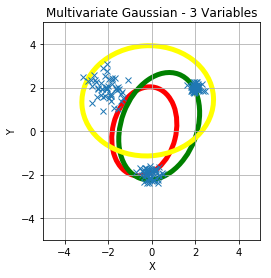

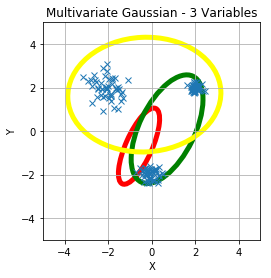

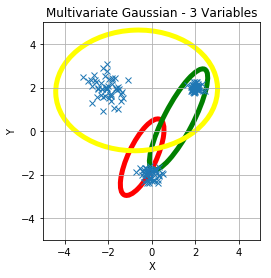

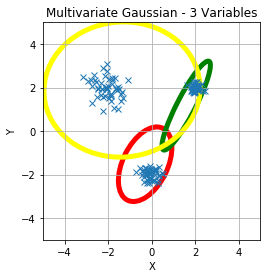

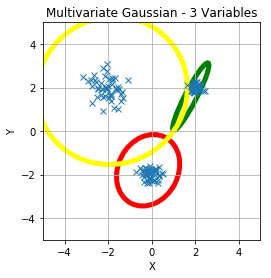

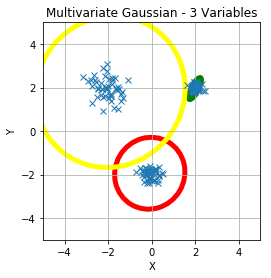

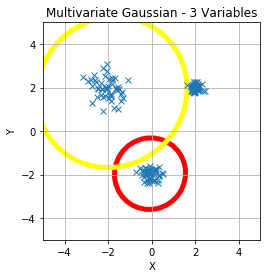

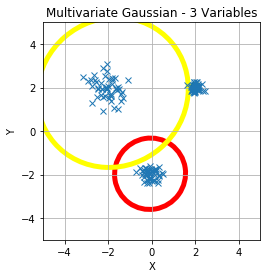

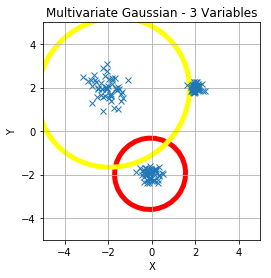

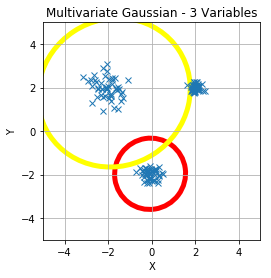

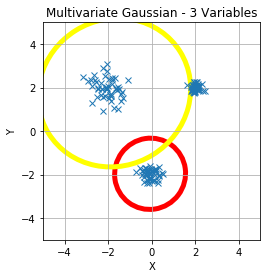

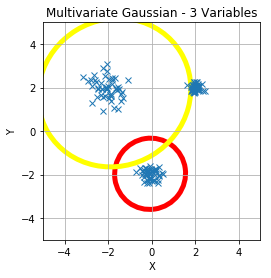

The estimates of the parameters of the Gaussians are: 
Mu: [array([-0.0731186 , -1.96467648]), array([2.00171041, 1.99888234]), array([-1.70955133,  1.77110927])]
Covariance: [array([[ 1.18309055, -0.01734845],
       [-0.01734845,  1.19318767]]), array([[0.0076038 , 0.00195879],
       [0.00195879, 0.01054975]]), array([[ 5.4730844 , -0.27257454],
       [-0.27257454,  5.19264304]])]


In [8]:
# Initialize total number of points (n), number of clusters (k),
# mixing weights (pi), means (mu) and covariance matrices (cov)
n_points = 150 # 150 points total
k = 3  # we know there are 3 clusters
mu = [(3 - (-3)) * np.random.rand(2,1) + (-3) for _ in np.arange(k)]
cov = [10 * np.identity(2) for _ in np.arange(k)]
n_per_cluster = [n_points/k for _ in np.arange(k)] # even split for now
pi = n_per_cluster

mu_estimate, cov_estimate = ExpectationMaximization_GMM(data, n_per_cluster, n_points, k, pi, mu, cov)
print("The estimates of the parameters of the Gaussians are: ")
print("Mu:", mu_estimate)
print("Covariance:", cov_estimate)

**d. Conclusion.** This dataset is linearly separable; k-means would also separate this data nicely, and is much easier to implement. In this case, the clusters are well differenciated so a hard-clustering algorithm like k-means would be easier to implement and yield the same result as EM. EM is preferred in cases where data is not linearly separable, i.e. it is not clear whether some points belong to one cluster on another. EM will assign a probability instead of a hard assignment to deal with these ambiguous data sets.